### Notebook for extracting and categorizing AI policies in course outlines*


Sean Rehaag


13 February 2026 (upated Feb 22)


Due to concerns related to security (e.g. zoom links, course times and locations) outlines are not included in this repo. However, they are available on MyOsgoode via Passport York. They can be downloaded manually and put into DATA/F25/ and DATA/W26/ -- or this process can be automated via scrape_outlines.py.

(* Code generated with the assistance of Github Copilot)

In [ ]:
# load all pdf files in DATA/F25/
import os
import glob
import warnings
import logging

pdf_files = glob.glob(os.path.join("DATA", "F25", "*.pdf")) + glob.glob(os.path.join("DATA", "W26", "*.pdf"))

# get text from files, and put in df, with cols, filename, text
import pandas as pd
from PyPDF2 import PdfReader

# Suppress all PyPDF2 warnings due to formatting issues 
warnings.filterwarnings("ignore")
logging.getLogger("PyPDF2").setLevel(logging.ERROR)

df = pd.DataFrame(columns=["filename", "text"])
for pdf_file in pdf_files:
    reader = PdfReader(pdf_file)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    df = pd.concat([df, pd.DataFrame([{"filename": os.path.basename(pdf_file), "text": text}])], ignore_index=True)

# clean df by removing duplicates and readings only files
df = df.drop_duplicates(subset=["filename"], keep="first").reset_index(drop=True)
df = df[~df["filename"].isin([
    "LAW 1010 Contracts - Small Group Readings F25 Penney (Tentative).pdf",
    "LAW 1010 Contracts F25 Reading List McCamus.pdf",
    "LW 7400, LW 7410, LW 7420 IP Intensive - Reading List - F25 Turcotte.pdf"
])].reset_index(drop=True)

In [ ]:
# use openai api to extract info from course outline text

from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()  # Load environment variables from .env file, including OPENAI_API_KEY

client = OpenAI()

instructions_extract = """You are a helpful assistant to a Canadian law professor. 
You are given a course outline from Osgoode Hall Law School, and your task is to 
extract the text of any INSTRUCTOR-AUTHORED policies relating to the use of AI 
(including generative AI, ChatGPT, Copilot, or similar tools).

WHAT TO EXTRACT:
- Any passage where the instructor sets out their own course-specific rules, 
  permissions, restrictions, or expectations regarding student use of AI.
- Include surrounding context (e.g., the heading under which the policy appears) 
  so the policy can be understood in context.
- If the instructor's AI policy is spread across multiple sections of the outline 
  (e.g., mentioned in a "Course Policies" section and again under a specific 
  assignment description), extract each passage.

WHAT TO EXCLUDE:
- The entire section headed "OSGOODE AND YORK ACADEMIC POLICIES" or any 
  substantially similar heading. This is university-wide boilerplate found in 
  every course outline and includes references to the York Senate Academic Conduct 
  Policy and Procedures, rules on cheating, plagiarism, paraphrasing, and 
  collaborative study materials. Exclude ALL of it.

OUTPUT FORMAT:
- Return each distinct policy passage separated by:
  ===
- Preserve the original wording of each passage (extract verbatim, do not 
  paraphrase or summarize).
- If the outline contains NO instructor-authored AI policy outside the 
  boilerplate section, return exactly:
  NO_POLICY_FOUND"""

instructions_categorize = """You are a helpful assistant to a Canadian law professor. 
You are given a  course outline from Osgoode Hall Law School. Your task is to 
categorize the INSTRUCTOR'S OWN course-specific AI policy into one of the 
following categories.

IMPORTANT: Ignore entirely any text that falls under the heading "OSGOODE AND YORK 
ACADEMIC POLICIES" or that reproduces provisions of the York Senate Academic Conduct 
Policy and Procedures. These are university-wide boilerplate rules included in every 
course outline. You are ONLY categorizing the policy the individual instructor has set 
for their specific course.

CATEGORIES:

0 - No instructor policy found: The course outline contains no instructor-authored 
    policy on AI use (beyond the standard Osgoode/York boilerplate).
    Example: The outline discusses AI only in the "OSGOODE AND YORK ACADEMIC POLICIES" 
    section and nowhere else.

1 - Prohibition: AI use is flatly prohibited in this course (whether stated as a blanket 
    course prohibition or as a prohibition applying to all assessments).
    Example: "Use of AI is prohibited in this course. If you have any doubts as to 
    what that means, ask before using."

2 - Prohibited with possible change: AI use is currently prohibited, but the instructor 
    signals that this may change during the course.
    Example: "Use of AI is prohibited in this course unless and to the extent that 
    the instructor permits it. At the moment, no use is permitted but this could 
    change as the course proceeds."

3 - Grammar and mechanics only: AI use is prohibited except for correction of grammar, 
    spelling, punctuation, idiom, and sentence mechanics.
    Example: "The only permitted use of AI is, consistent with section 5.3.a.x. of 
    the Senate Academic Conduct Policy and Procedures, for purposes of correction of 
    grammar, idiom, punctuation, spelling and sentence mechanics (and nothing beyond)."

4 - Limited permission (specific uses beyond grammar): AI is permitted for identified 
    purposes (e.g., brainstorming, research, outlining, summarizing readings) but 
    expressly prohibited for others (e.g., drafting or generating submitted content). 
    Disclosure may or may not also be required.
    Example: "You may use AI tools to brainstorm ideas and organize your thinking, 
    but you may not use AI to draft any portion of your submitted work."

5 - Generally permitted with conditions: AI use is broadly allowed but subject to 
    conditions such as mandatory disclosure, attribution, documentation of prompts, 
    or a requirement that students verify and take responsibility for AI-generated content.
    Example: "Use of AI is permitted in this course, but you must disclose any use of 
    AI in your work and specify the nature and extent of that use."

6 - Encouraged or required: The course actively encourages or requires students to 
    use AI tools as part of the learning objectives or specific assignments.
    Example: "In this course you will be expected to use AI tools as part of the 
    practical exercises. We will explore both the capabilities and limitations of 
    these tools."

7 - Other: Any instructor-authored AI policy that does not clearly fit into 
    categories 1-6.

DECISION RULES:
- If a policy spans multiple categories (e.g., permits specific uses AND requires 
  disclosure), choose the category that best captures the DOMINANT restriction or 
  permission. Ask: what is the overall posture — restrictive with narrow exceptions, 
  or permissive with conditions?
- Categories 1-3 reflect a predominantly RESTRICTIVE posture (no → maybe later → 
  grammar only).
- Categories 4-6 reflect a predominantly PERMISSIVE posture (some uses → broad use 
  with conditions → encouraged/required).

RETURN ONLY THE CATEGORY NUMBER (0-7) AND NOTHING ELSE."""

instructions_name = """You are a helpful assistant to a Canadian law professor. You
are given a course outline and you return ONLY the name of the instructor and the name
of the case, following this format: FIRST NAME LAST NAME: Course Name. For example:
SEAN REHAAG: Refugee Law
Where the course outline does not include either the instructor's name or the course
name, indicate unknown. For example:
Unknown: Commercial Law.
Where the course outline includes multiple instructors, separate their names by commas.
RETURN ONLY THE REQUESTED INFORMATION WITH NO EXPLANATION."""


def get_response(text, instructions, model = "gpt-5-mini", effort = "medium"):
    response = client.responses.create(
                    model=model,
                    text={"verbosity": "low"},
                    reasoning={
                        "effort": effort,
                    },
                    instructions=instructions,
                    input=text
                )
    return response.output_text.strip()

# Run data parsing
df['name'] = df['text'].apply(
    lambda x: get_response(x, instructions_name, model="gpt-5-nano", effort="low"))
df["policies_text"] = df["text"].apply(
    get_response, args=(instructions_extract,))
df["policy_category"] = df["text"].apply(
    get_response, args=(instructions_categorize,))

# export df to json indent 4
df.to_json("DATA/output.json", orient="records", indent=4)


category_label
No policy found                  7
Prohibition                     55
Prohibited (possible change)    22
Grammar only                    61
Limited permission              33
Permitted with conditions       13
Encouraged/required              1
Other                            0
Name: count, dtype: int64


<Axes: title={'center': 'Instructor AI Policies — Osgoode Hall Law School'}, ylabel='category_label'>

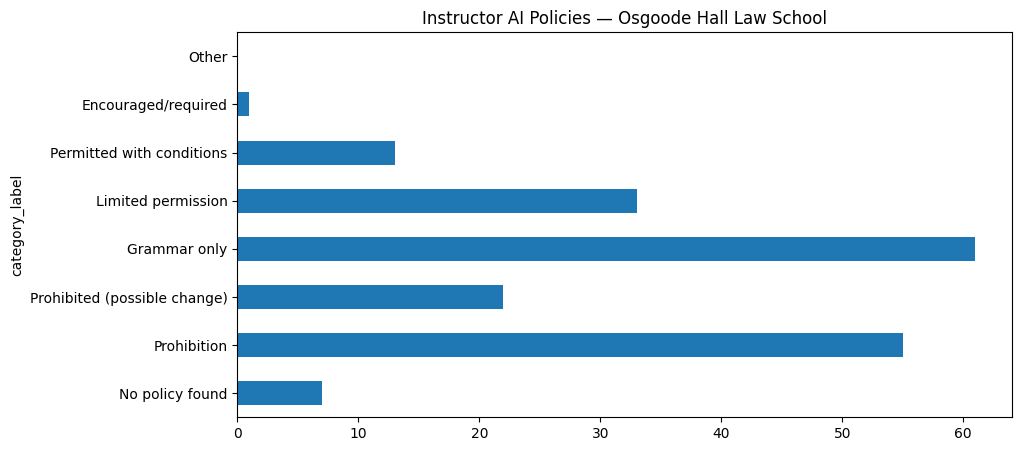

In [16]:
category_labels = {
    0: "No policy found",
    1: "Prohibition",
    2: "Prohibited (possible change)",
    3: "Grammar only",
    4: "Limited permission",
    5: "Permitted with conditions",
    6: "Encouraged/required",
    7: "Other"
}

df['category_label'] = df['policy_category'].astype(int).map(category_labels)

summary = df['category_label'].value_counts().reindex(category_labels.values(), fill_value=0)
print(summary)

summary.plot.barh(figsize=(10, 5), title='Instructor AI Policies — Osgoode Hall Law School')

category_label_consolidated
No policy found               7
Prohibited                   77
Grammar only                 61
Limited permission           33
Permitted with conditions    14
Other                         0
Name: count, dtype: int64

24.5% of courses permit some AI use beyond grammar correction.



<Axes: title={'center': 'Instructor AI Policies — Osgoode Hall Law School'}, ylabel='category_label_consolidated'>

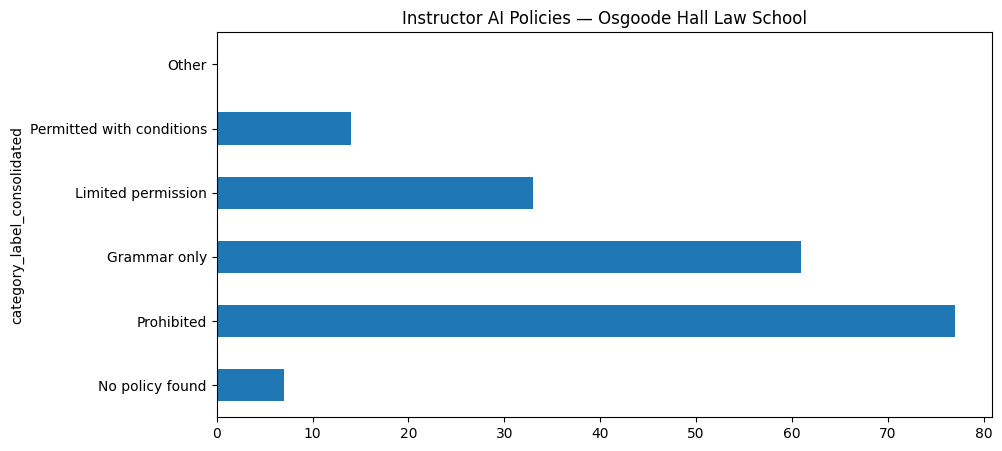

In [23]:
# Analysis with consolidation
category_labels_consolidated = {
    0: "No policy found",
    1: "Prohibited",
    2: "Prohibited",
    3: "Grammar only",
    4: "Limited permission",
    5: "Permitted with conditions",
    6: "Permitted with conditions",
    7: "Other"
}

df['category_label_consolidated'] = df['policy_category'].astype(int).map(category_labels_consolidated)

summary = df['category_label_consolidated'].value_counts().reindex(
    ["No policy found", "Prohibited", "Grammar only", "Limited permission", "Permitted with conditions", "Other"],
    fill_value=0)
print(summary)
print()
pct = (summary["Limited permission"] + summary["Permitted with conditions"]) / summary.sum() * 100
print(f"{pct:.1f}% of courses permit some AI use beyond grammar correction.")
print()

summary.plot.barh(figsize=(10, 5), title='Instructor AI Policies — Osgoode Hall Law School')

In [ ]:
# sanity check: # get random sample of 10 cases and print df for manual review

display(df[['filename', "name", 'policy_category', 'category_label', 'policies_text']].sample(10, random_state=111))

# Manual review indicates 
#55:  ok #35: ok  #104: ok #23: ok  #11:  ok
#160: ok #73: ok  #145: ok #159: ok #176: ok

print ("""Manual review indicates all categorizations in a sample of 10 are correct.
However, if relying on this analysis for any important purpose beyond a general overview,
a more thorough manual review and validation is recommended.""")



,filename,name,policy_category,category_label,policies_text
55,LAW 3960 Lawyer as Negotiator F25 Odumeru.pdf,Jonathan Odumeru: Lawyer as Negotiator,2,Prohibited,d. Instructor’s policy on AI : \n Osgoode Hall...
35,LAW 2315 Labour & Employmen F25 Smith.pdf,ADRIAN SMITH: Labour and Employment Law,3,Grammar only,d. Instructor’s policy on AI : \n \nUse of AI ...
104,CONDON - Advanced Securities - Course Outline ...,MARY CONDON: Advanced Securities(5280),3,Grammar only,Course Feedback and Discussing Final Grade : ...
23,LAW 2040 Conflict of Laws F25 Walker.pdf,JANET WALKER: Conflict of Laws,1,Prohibited,d. Use of AI and Collaborative Study Material...
11,KIDD WHITE - LAW 2720 Jurisprudence F25.pdf,EMILY KIDD WHITE: Jurisprudence,1,Prohibited,iii) Examination Our final examination is wor...
160,Monkhouse - LAW 6022 Mooting Appellate Advocac...,ANDREW MONKHOUSE: Mooting: Appellate Advocacy ...,4,Limited permission,d. Instructor’s policy on AI: \n \nUse of Lar...
73,MATTHEWS - ICL - Course Outline - F25 - LW 244...,HEIDI MATTHEWS: International Criminal Law,1,Prohibited,ii. Short writing assignments (40%) \n \nStud...
145,"LAW 7910, LAW 7920 Anti-Discrimination Intensi...",FAISAL BHABHA: ADIP Seminar and Research Paper,5,Permitted with conditions,Instructor’ Policy on AI : The use of AI in th...
159,Mgbeoji - Trademarks Course Outline -2026- W26...,IKECHI MGbeoji: TRADEMARK LAW (2170.04),1,Prohibited,"Use of AI \nIn this course, every element of ..."
176,REHAAG - LEGAL INFO TECH - Course Outline - W2...,SEAN REHAAG: LEGAL INFO TECH: DATA ANALYSIS & ...,5,Permitted with conditions,7. Learning Objectives \n By the end of this ...


Manual review indicates all categorizations in a sample of 10 are correct.
However, if relying on this analysis for any important purpose beyond a general overview,
a more thorough manual review and validation is recommended.
